In [1]:
import ufl
from ufl import  TrialFunction, TestFunction, FacetNormal, lhs, rhs,SpatialCoordinate

import dolfinx
from dolfinx import mesh, fem, io
from dolfinx.fem import FunctionSpace, VectorFunctionSpace, locate_dofs_geometrical, form
from dolfinx.fem.petsc import LinearProblem

from mpi4py import MPI
import petsc4py.PETSc
import numpy as np
import matplotlib.pyplot as plt


# Operators:
class Infix:

    def __init__(self, function):
        self.function = function

    def __ror__(self, other):
        return Infix(lambda x, self=self, other=other: self.function(other, x))

    def __or__(self, other):
        return self.function(other)

    def __call__(self, value1, value2):
        return self.function(value1, value2)


dot = Infix(ufl.inner)
from ufl import dx, ds, exp
from ufl import nabla_div as div
from ufl import nabla_grad as grad

npor = Infix(np.logical_or)
npand = Infix(np.logical_and)

# Classes:


def Function(space, func=None):
    """Function on new space. Default create just Function on space

    Args:
        space (FunctionSpace): New space
        function (): Ufl_function, fem.Function, callable function, fem.Constant, constant

    Returns:
        fem.Function: Function
    """
    if func == None: return fem.Function(space)

    result = fem.Function(space)

    if not callable(func):
        expression = lambda x: x[0] * 0 + func

    elif hasattr(func, 'function_space'):
        expression = func

    elif hasattr(func, 'value'):
        expression = lambda x: x[0] * 0 + func.value

    elif hasattr(func, 'ufl_domain'):
        expression = fem.Expression(func, space.element.interpolation_points())
    else:
        expression = func

    result.interpolate(expression)
    return result


def Constant(space, const):
    """Constant on space

    Args:
        space (fem.FunctionSpace): Space
        const (auny number): Any number

    Returns:
        fem.function.Constant: Constant on space
    """
    return fem.Constant(space, petsc4py.PETSc.ScalarType(const))


def create_facet_markers(domain, bound_markers):
    """Mark facets under conditious

    Args:
        domain (Domain): Domain
        bound_markers (mark,python_function): List of mark and function
    
    Return:
        tags(mesh.meshtags): Marked facets
    """
    facet_indices, facet_markers = [], []
    for (marker, condition) in bound_markers:
        facets = mesh.locate_entities(
            domain,
            domain.topology.dim - 1,
            condition,
            )
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)
    sorted_facets = np.argsort(facet_indices)
    facet_tags = mesh.meshtags(
        domain,
        domain.topology.dim - 1,
        facet_indices[sorted_facets],
        facet_markers[sorted_facets],
        )

    return facet_tags


def create_connectivity(domain):
    """Need to compute facets to Boundary value

    Args:
        domain (Mesh): Domain
    """
    domain.topology.create_connectivity(
        domain.topology.dim - 1,
        domain.topology.dim,
        )


def DirichletBC(space, func, combined_marker):
    """Create Dirichlet condition

    Args:
        space (fem.FunctionSpace): Function space
        func (fem.function): Function or Constant
        combined_marker (Any): One from next
        \nFunction - boundary marker function
        \nAll - all boundary
        \n(mesh.meshtags, marker) - list or tuple, marker of boundary from Marked_facets - mesh.meshtags
        
    Returns:
        condition (dirichletbc): Dirichlet condition
    """

    def get_exterior_facets():
        exterior_facets = mesh.exterior_facet_indices(domain.topology)
        return exterior_facets

    def all_dirichlet(dofs, func):
        if hasattr(func, 'function_space'):
            bc = fem.dirichletbc(dofs=dofs, value=func)
        else:
            bc = fem.dirichletbc(V=space, dofs=dofs, value=func)
        return bc

    domain = space.mesh

    if combined_marker == 'All':
        facets = get_exterior_facets()
        dofs = fem.locate_dofs_topological(
            space,
            domain.topology.dim - 1,
            facets,
            )

    elif type(combined_marker) == (tuple or list):
        marked_facets, marker = combined_marker
        facets = marked_facets.find(marker)
        dofs = fem.locate_dofs_topological(
            space,
            domain.topology.dim - 1,
            facets,
            )
    else:
        dofs = fem.locate_dofs_geometrical(space, marker=combined_marker)

    bc = all_dirichlet(dofs, func)

    return bc


# Post processing:
def errors_L(uS, uEx):
    """Compute error norm on boundary

    Args:
        uS (Function): Numeric solution
        uEx (Function): Exact or model solution

    Returns:
        List: L1 and L2 norms
    """
    domain = uS.function_space.mesh

    V_err = FunctionSpace(
        domain,
        ('CG', uS.function_space.element.space_dimension),
        )
    uEx = Function(V_err, uEx)
    L1_scalar = fem.assemble_scalar(form((uS-uEx) * dx))
    L2_scalar = fem.assemble_scalar(form((uS - uEx)**2 * dx))

    L1_err = np.abs(domain.comm.allreduce(L1_scalar, op=MPI.SUM))
    L2_err = np.sqrt(domain.comm.allreduce(L2_scalar, op=MPI.SUM))
    return (L1_err, L2_err)


def line_collision(domain, line_cord):
    """Generate points and cells of colliding domain and line

    Args:
        domain (mesh): Domain
        line_cord (array): 3D line contervertor of coordinates 

    Returns:
        Tuple: Collision points and collision cells
    """
    bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)

    cells_on_line = []
    points_on_line = []
    cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, line_cord.T)
    colliding_cells = dolfinx.geometry.compute_colliding_cells(
        domain, cell_candidates, line_cord.T
        )
    for i, point in enumerate(line_cord.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_line.append(point)
            cells_on_line.append(colliding_cells.links(i)[0])

    points_on_line = np.array(points_on_line, dtype=np.float64)

    return (points_on_line, cells_on_line)


def graph2D(fig, lists, natural_show=False, points_on=False):
    """Create graph from fem.Function

    Args:
        fig (plt.Figure): Figure
        lists (fem.Function , plt.Axes, str): List of (u, curent axes, title)
        method (bool): Graph method True = tripcolor, False = tricontourf
    """

    def data_construct(dofs, x_array):
        data = np.column_stack((dofs[:, 0:2], x_array))
        x_data = data[:, 0]
        y_data = data[:, 1]
        z_data = data[:, 2]
        return [x_data, y_data, z_data]

    for list in lists:
        fig, ax = plt.subplots()
        plt.close()
        u, ax, title = list
        dofs = u.function_space.tabulate_dof_coordinates()
        ax.set_title(title)
        data = data_construct(dofs, u.x.array)

        if points_on: ax.plot(data[0], data[1], 'o', markersize=2, color='grey')

        if natural_show:
            plot = ax.tripcolor(*data)
        else:
            try:
                levels = np.linspace(u.x.array.min(), u.x.array.max(), 10)
                plot = ax.tricontourf(
                    *data,
                    levels=levels,
                    )
            except:
                print(f'{title} - error')

        ax.set_aspect(1)
        fig.colorbar(plot, ax=ax)
    return

In [26]:
N = 100
Nt = 50
T = 1
dt = T / Nt
domain = mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=[[-1, -1], [1, 1]],
    n=(N, N),     # cell_type=mesh.CellType.quadrilateral,
    )
create_connectivity(domain=domain)
V = FunctionSpace(domain, ('CG', 1))

u, v = TrialFunction(V), TestFunction(V)
x, y = SpatialCoordinate(V)
ds = ufl.Measure("ds", domain=domain)
dx = ufl.Measure('cell', subdomain_id='everywhere')

f = Constant(V, 0)
uD = Constant(V, 0)
u0 = Function(V, exp(-5 * (x**2 + y**2)))
u1 = Function(V, u0)

uS = Function(V, u0)
bcs = [
    DirichletBC(
        space=V,
        func=uD,
        combined_marker='All',
        ),
    ]

F = u*v*dx + dt * (grad(u)|dot|grad(v)) * dx - dt*f*v*dx - u0*v*dx

In [27]:
bilinear_form = fem.form(form=lhs(F))
linear_form = fem.form(form=rhs(F))

A = fem.petsc.assemble_matrix(bilinear_form, bcs)
A.assemble()
b = fem.petsc.create_vector(linear_form)

solver = petsc4py.PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(petsc4py.PETSc.KSP.Type.PREONLY)
solver.getPC().setType(petsc4py.PETSc.PC.Type.LU)

In [28]:
with io.VTKFile(domain.comm, 'Heat_Files/heat.pvd', 'w') as file:
    for t in np.arange(0, T + dt, dt):
        file.write_function(u0, t)
        u0.interpolate(uS)
        # Cleaning linear_form solution
        with b.localForm() as loc_b:
            loc_b.set(0)
        fem.petsc.assemble_vector(b, linear_form)

        # Apply Dirichlet to the b
        fem.petsc.apply_lifting(b, [bilinear_form], [bcs])
        b.ghostUpdate(
            addv=petsc4py.PETSc.InsertMode.ADD_VALUES,
            mode=petsc4py.PETSc.ScatterMode.REVERSE,
            )
        fem.petsc.set_bc(b, bcs)

        # Solving
        solver.solve(b, uS.vector)
        uS.x.scatter_forward()

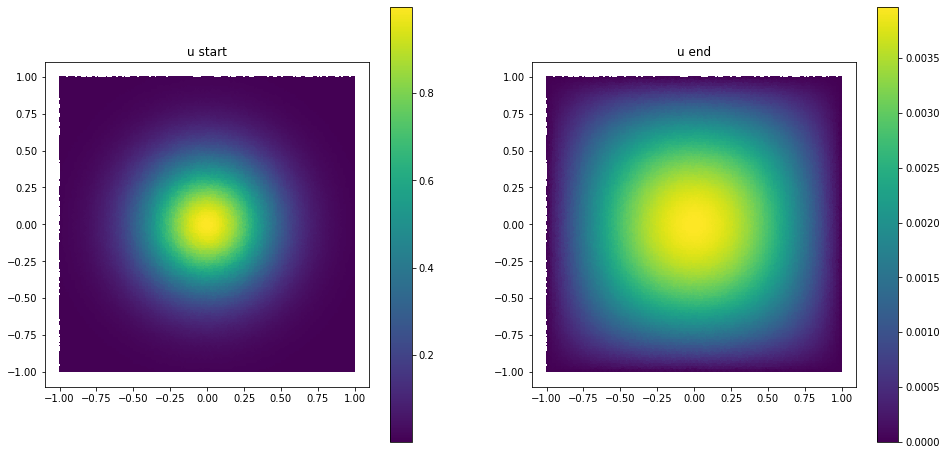

In [29]:
fig, (ax, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
graph2D(
    fig=fig,
    lists=[
        [u1, ax, 'u start'],
        [u0, ax2, 'u end'],
        ],
    natural_show=True,     # points_on=True,
    )